In [2]:
import pyabf 


abf = pyabf.ABF("data/2025_12_04_0001.abf")  # load the file
abf.setSweep(0,channel= 0)  # Channel 0 is recording channel
spike_ch = abf.sweepY.copy()
time_vec = abf.sweepX.copy()

abf.setSweep(0,channel= 2)  # Channel 2 is Stim channel
stim_ch = abf.sweepY.copy()
stim_ch_m = max(stim_ch)
stim_ch = (stim_ch-stim_ch_m)*-1


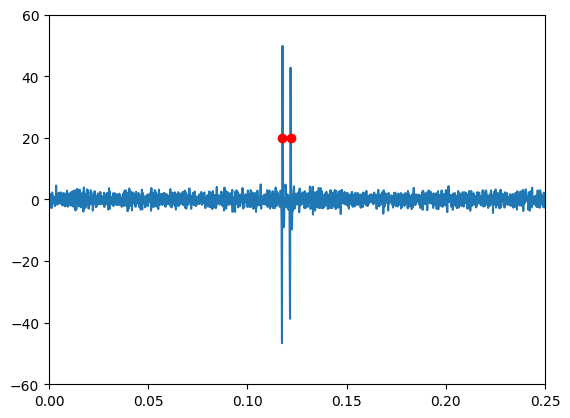

(np.float64(0.0), np.float64(5.0), np.float64(-60.0), np.float64(60.0))

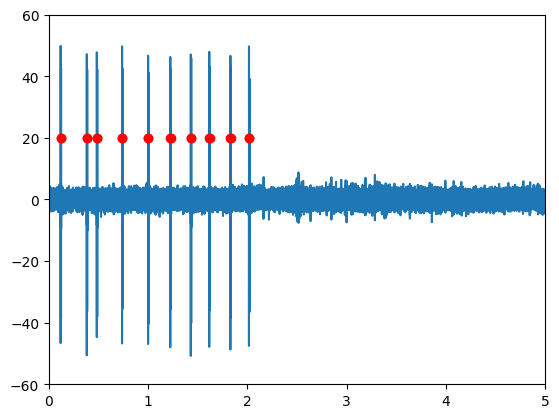

In [3]:
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
peaks, _ = find_peaks(spike_ch, height = 20)
plt.plot(time_vec,spike_ch)
plt.plot(peaks/2e4,[20]*len(peaks),'o',c = 'red')
plt.axis([0, 0.25, -60, 60])
plt.show()


plt.plot(time_vec,spike_ch)
plt.plot(peaks/2e4,[20]*len(peaks),'o',c = 'red')
plt.axis([0, 5, -60, 60])

In [4]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d

# Change filename as needed
df = pd.read_csv("data/2025_12_04_0001.csv", header=None)


t_60 = df.iloc[:, 1].to_numpy()  
x_60 = df.iloc[:, 2].to_numpy()  


order = np.argsort(t_60)
t_60 = t_60[order]
x_60 = x_60[order]


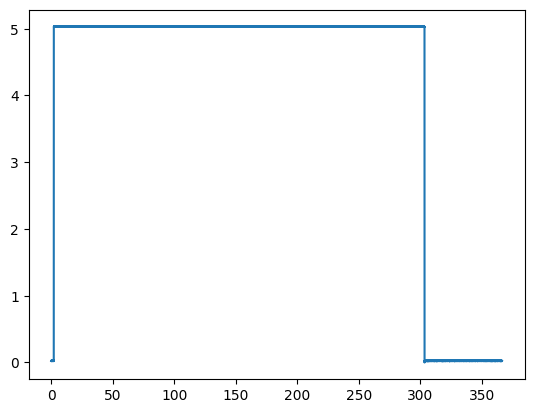

In [11]:
plt.plot(time_vec,stim_ch)

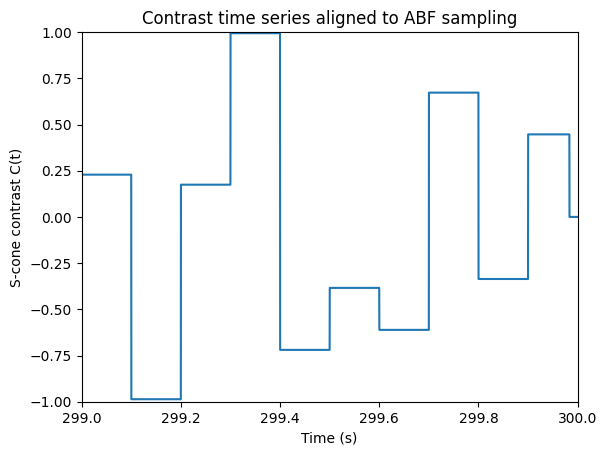

In [9]:
import matplotlib.pyplot as plt
import numpy as np

is_on = stim_ch > 1
edges = np.diff(is_on.astype(int))
fall_idxs = np.where(edges == -1)[0] + 1  
rise_idxs = np.where(edges ==  1)[0] + 1   

i_on = rise_idxs[0]
i_off  = fall_idxs[0]


t_on  = time_vec[i_on]
t_off = time_vec[i_off]


csv = pd.read_csv("data/2025_12_04_0001.csv")

t_60 = csv.iloc[:, 1].to_numpy()
y_60 = csv.iloc[:, 2].to_numpy()

y0 = y_60.mean()
C_60 = (y_60 - y0) / y0

contrast_interp = interp1d(
    t_60, C_60,
    kind='previous',     
    bounds_error=False,
    fill_value=(0.0, 0.0)
)
C_20k = contrast_interp(time_vec)   

plt.plot(time_vec, C_20k)
plt.xlabel("Time (s)")
plt.ylabel("S-cone contrast C(t)")
plt.title("Contrast time series aligned to ABF sampling")
plt.axis([299,300,-1,1])
plt.show()

segments.shape: (2698, 4000)


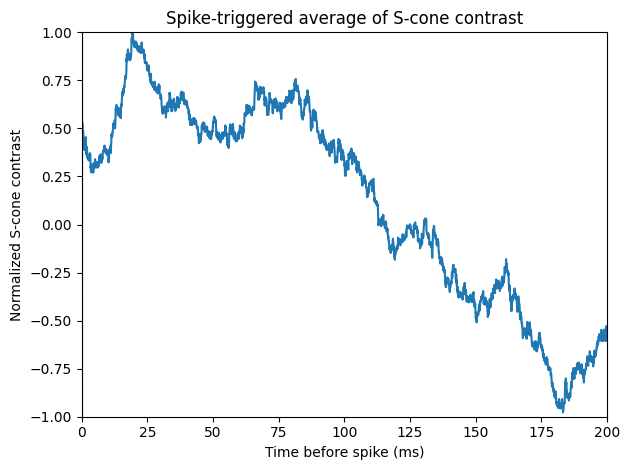

In [17]:
import numpy as np

dt = np.mean(np.diff(time_vec))
fs = 1.0 / dt

window_s = 0.2   # 200 ms
window_n = int(window_s * fs)


spike_times = time_vec[peaks]

mask_spikes = (spike_times >= t_on + 1.0) & (spike_times <= t_off)
peaks_used  = peaks[mask_spikes]

segments = []

for p in peaks_used:

    if p < window_n:
        continue
    if p > len(C_20k):
        continue

    seg = C_20k[p - window_n : p]

    if len(seg) == window_n:
        segments.append(seg)

segments = np.array(segments)  
print("segments.shape:", segments.shape)

sta = segments.mean(axis=0)


sta_rev = sta[::-1]
peak_sta = np.max(np.abs(sta_rev))
sta_norm = sta_rev / peak_sta

lags_ms = np.arange(window_n) * dt * 1000

plt.figure()
plt.plot(lags_ms, sta_norm)
plt.axvline(0, color='k', linestyle='--', linewidth=0.8)
plt.xlabel("Time before spike (ms)")
plt.ylabel("Normalized S-cone contrast")
plt.title("Spike-triggered average of S-cone contrast")
plt.axis([0, 200,-1,1])
plt.tight_layout()
plt.show()


In [1]:
from Neitz import Neitz
from pathlib import Path

x = Neitz(filepath=Path.cwd())
x.abfread("2025_12_04_0001.abf")
x.find_spikes()
x.find_stim_on_off()
x.load_csv("2025_12_04_0001.csv")
x.align_contrast()
x.compute_sta()

time_vec = x.time_vec
spike_ch = x.spike_ch
stim_ch = x.stim_ch
peaks = x.peaks
sta_norm = x.sta_norm


TypeError: ufunc 'divide' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

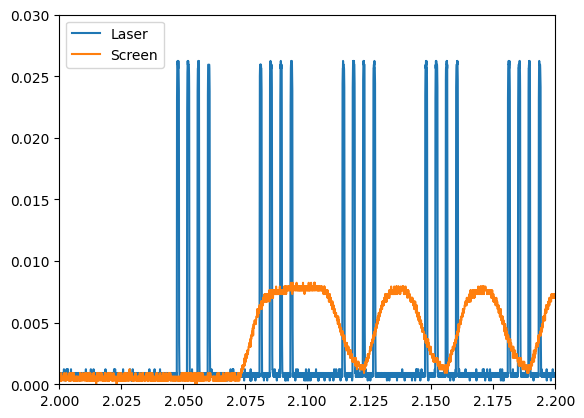

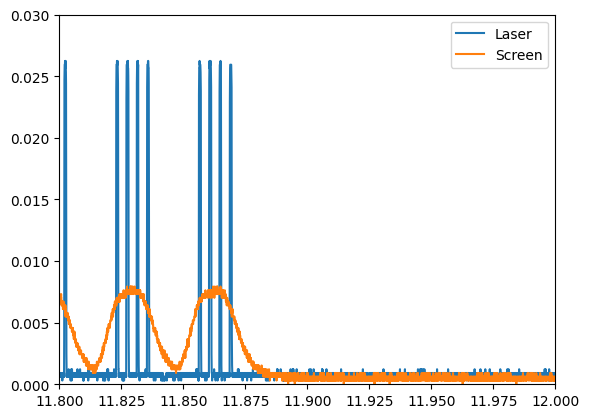

In [2]:
from Neitz import Neitz
from pathlib import Path
import matplotlib.pyplot as plt

laser = Neitz(filepath=Path.cwd())
laser.abfread("2025_12_18_0002_laser.abf")
laser.stim_ch = (laser.stim_ch)*-1
laser.stim_ch = laser.stim_ch - min(laser.stim_ch)

screen = Neitz(filepath=Path.cwd())
screen.abfread("2025_12_18_0001_screen.abf")
screen.stim_ch = (screen.stim_ch)*-1
screen.stim_ch = screen.stim_ch - min(screen.stim_ch)

plt.plot(laser.time_vec ,laser.stim_ch)
plt.plot(screen.time_vec ,screen.stim_ch)
plt.axis([2, 2.2, 0, 0.03])
plt.legend(["Laser", "Screen"])


plt.figure()
plt.plot(laser.time_vec ,laser.stim_ch)
plt.plot(screen.time_vec ,screen.stim_ch)
plt.axis([11.8, 12, 0, 0.03])
plt.legend(["Laser", "Screen"])

<function matplotlib.pyplot.show(close=None, block=None)>

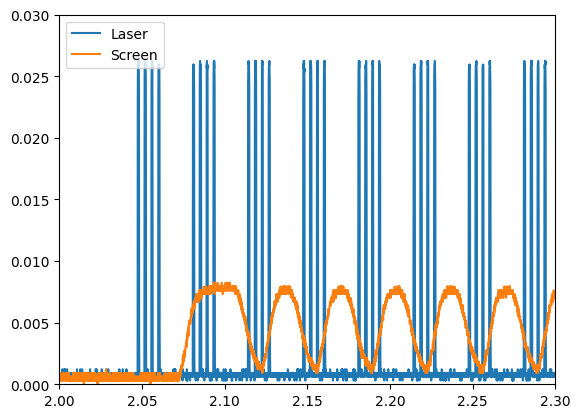

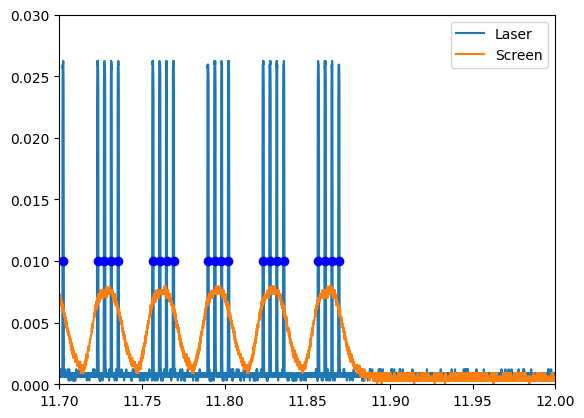

In [96]:
from scipy.signal import find_peaks
laser.peak_height = 0.01
laser.peaks, _ = find_peaks(laser.stim_ch, laser.peak_height,distance=int(1/1000*2e4))

fs = screen.fs 
screen.peak_height     = 0.004      
min_distance_s  = 1/60      # 10 ms between peaks (adjust as needed)
min_distance_n  = int(min_distance_s * fs)

screen.peaks, _ = find_peaks(
    screen.stim_ch,
    height=screen.peak_height,
    distance=min_distance_n
)
# screen.peaks, _ = find_peaks(screen.stim_ch, screen.peak_height)

plt.figure()
plt.plot(laser.time_vec ,laser.stim_ch)
plt.plot(screen.time_vec ,screen.stim_ch)
plt.axis([2, 2.3,0,0.03 ])
plt.legend(["Laser", "Screen"],loc= "upper left")


plt.figure()
plt.plot(laser.time_vec ,laser.stim_ch)
plt.plot(screen.time_vec ,screen.stim_ch)
plt.plot(laser.peaks/2e4,[laser.peak_height]*len(laser.peaks),'o',c = 'blue')
# plt.plot(screen.peaks/2e4,[screen.peak_height]*len(screen.peaks),'o',c = 'orange')
plt.legend(["Laser", "Screen"])
plt.axis([11.7, 12,0,0.03 ])
plt.show



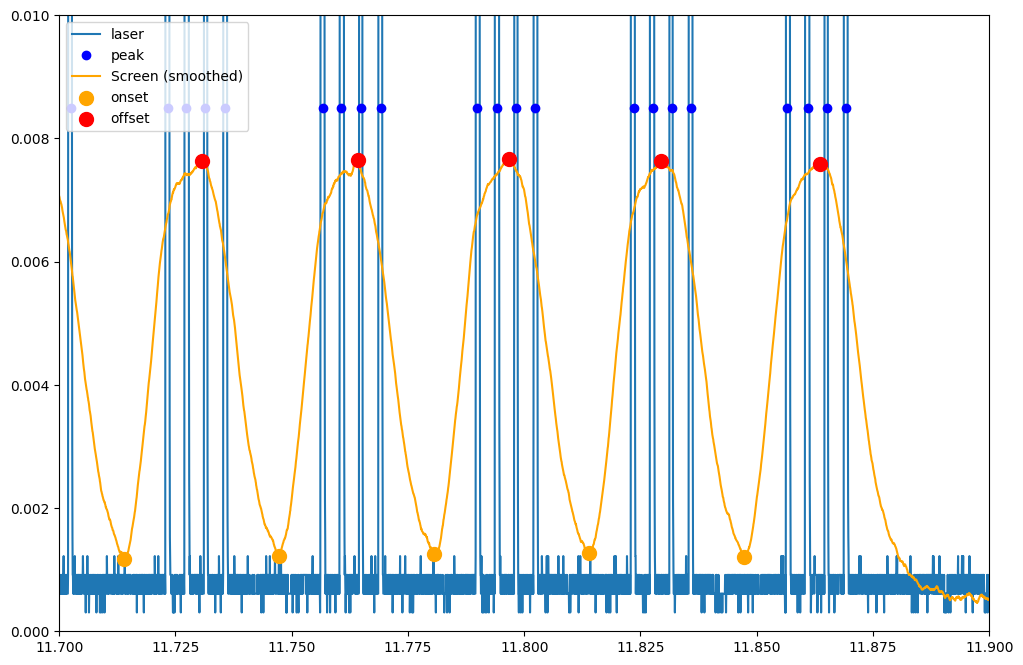

In [120]:
import numpy as np
from scipy.signal import find_peaks, savgol_filter
import matplotlib.pyplot as plt

sig_raw = screen.stim_ch
t       = screen.time_vec
fs      = screen.fs

# 1) Smooth
window_ms  = 2.5
window_len = int(window_ms * 1e-3 * fs)
if window_len % 2 == 0:
    window_len += 1
sig = savgol_filter(sig_raw, window_length=window_len, polyorder=3)

# 2) Maxima = offsets (tops)
max_idx, _ = find_peaks(
    sig,
    height=0.003,
    prominence=0.0005,
    distance=int(0.02 * fs)
)

# 3) Minima = candidates for onsets
min_idx, _ = find_peaks(
    -sig,
    prominence=0.0003,
    distance=int(0.01 * fs)
)

# 4) Pair: last min before each max (within a window)
on_idx_list  = []   # <<< reset as lists
off_idx_list = []

max_pre_window = 0.04  # seconds

for m in max_idx:
    prev = min_idx[(min_idx < m) & ((t[m] - t[min_idx]) < max_pre_window)]
    if prev.size == 0:
        continue
    on_idx_list.append(prev[-1])
    off_idx_list.append(m)

on_idx  = np.array(on_idx_list,  dtype=int)
off_idx = np.array(off_idx_list, dtype=int)

# 5) Manual first onset/offset based on "first rise from baseline"
baseline_mask = (t < 2.05)
baseline = sig[baseline_mask]
mu = baseline.mean()
sd = baseline.std()
thr_first = mu + 3*sd

search_mask    = (t > 2.05)
candidate_idx  = np.where(search_mask & (sig > thr_first))[0]
first_on_idx   = candidate_idx[0]
first_off_idx  = max_idx[max_idx > first_on_idx][0]

# prepend if earlier than current first
if on_idx.size == 0 or first_on_idx < on_idx[0]:
    on_idx  = np.concatenate(([first_on_idx],  on_idx))
    off_idx = np.concatenate(([first_off_idx], off_idx))

t_on  = t[on_idx]
t_off = t[off_idx]

# 6) Plot to check
plt.figure(figsize=(12,8))
plt.plot(laser.time_vec ,laser.stim_ch, label='laser')
plt.plot(laser.peaks/2e4,[laser.peak_height-0.0015]*len(laser.peaks),'o',c = 'blue', label='peak')
plt.plot(t, sig,               label="Screen (smoothed)", c= 'orange')
plt.scatter(t_on,  sig[on_idx],  c='orange', label='onset',s= 100,zorder = 4)
plt.scatter(t_off, sig[off_idx], c='red',   label='offset',s=100, zorder = 4)
plt.xlim(11.7, 11.9)
plt.ylim(0, 0.01)
plt.legend(loc='upper left')
plt.show()


293
295.0
33.6


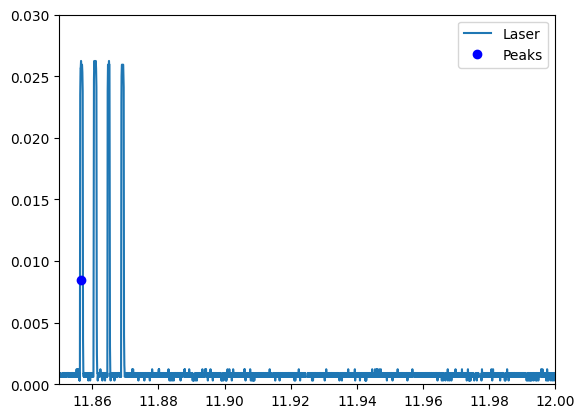

In [117]:
print(len(t_on))
print(len(laser.peaks)/4)
print(((laser.peaks[4]- laser.peaks[0])/2e4)*1000)
plt.plot(laser.time_vec ,laser.stim_ch, label='laser')
plt.plot(laser.peaks[0]/2e4,[laser.peak_height-0.0015],'o',c = 'blue', label='peak')
plt.plot(laser.peaks[-4]/2e4,[laser.peak_height-0.0015],'o',c = 'blue', label='peak')
plt.xlim(11.85, 12)
plt.ylim(0, 0.03)
plt.legend(['Laser','Peaks'])


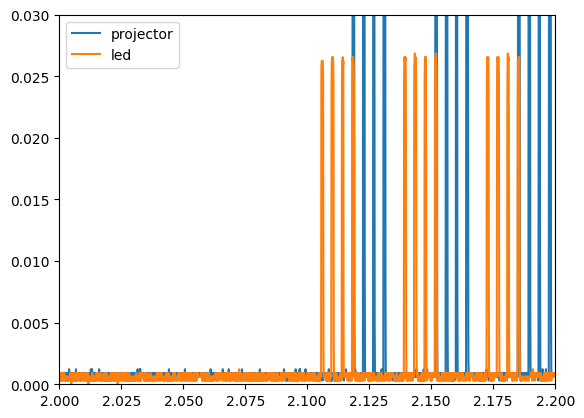

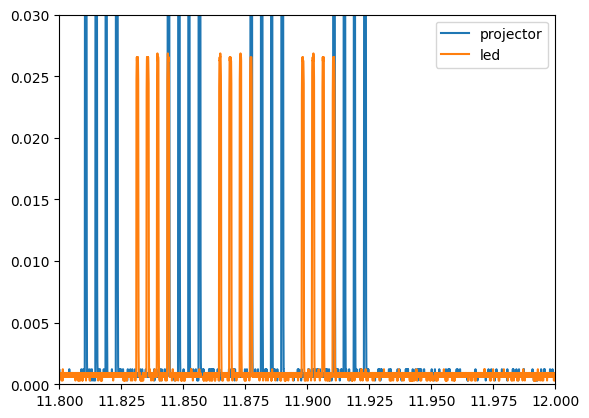

In [5]:
from Neitz import Neitz
from pathlib import Path
import matplotlib.pyplot as plt

projector = Neitz(filepath=Path.cwd())
projector.abfread("2026_01_01_0003_p.abf")
projector.stim_ch = (projector.stim_ch)*-1
projector.stim_ch = projector.stim_ch - min(projector.stim_ch)

led = Neitz(filepath=Path.cwd())
led.abfread("2026_01_01_0006_l.abf")
led.stim_ch = (led.stim_ch)*-1
led.stim_ch = led.stim_ch - min(led.stim_ch)

plt.plot(projector.time_vec ,projector.stim_ch)
plt.plot(led.time_vec ,led.stim_ch)
plt.axis([2, 2.2, 0, 0.03])
plt.legend(["projector", "led"])


plt.figure()
plt.plot(projector.time_vec ,projector.stim_ch)
plt.plot(led.time_vec ,led.stim_ch)
plt.axis([11.8, 12, 0, 0.03])
plt.legend(["projector_1", "led_1"])

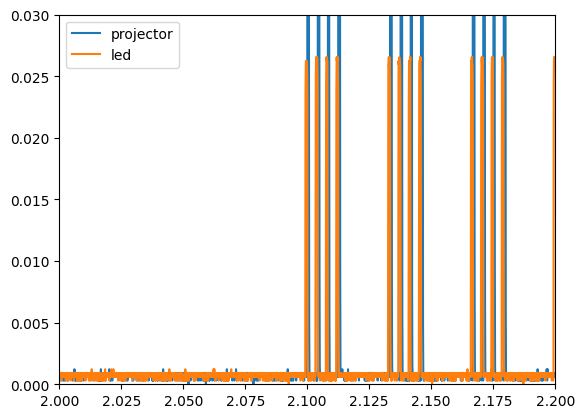

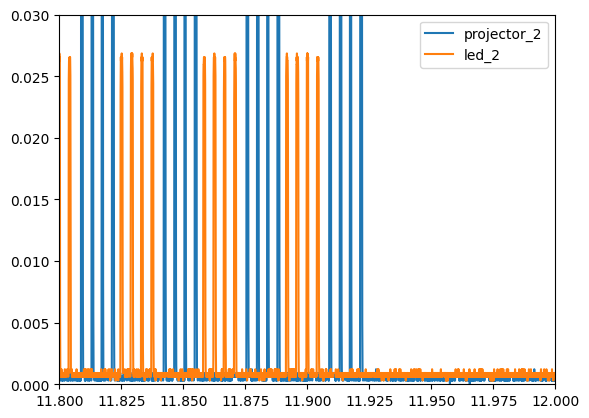

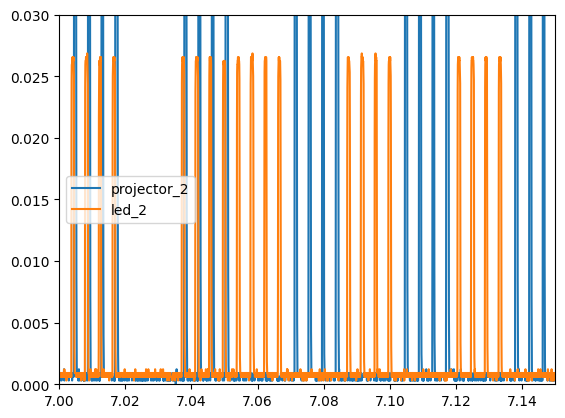

In [21]:
from Neitz import Neitz
from pathlib import Path
import matplotlib.pyplot as plt

projector = Neitz(filepath=Path.cwd())
projector.abfread("2026_01_01_0004_p.abf")
projector.stim_ch = (projector.stim_ch)*-1
projector.stim_ch = projector.stim_ch - min(projector.stim_ch)

led = Neitz(filepath=Path.cwd())
led.abfread("2026_01_01_0007_l.abf")
led.stim_ch = (led.stim_ch)*-1
led.stim_ch = led.stim_ch - min(led.stim_ch)

plt.plot(projector.time_vec ,projector.stim_ch)
plt.plot(led.time_vec ,led.stim_ch)
plt.axis([2, 2.2, 0, 0.03])
plt.legend(["projector", "led"])


plt.figure()
plt.plot(projector.time_vec ,projector.stim_ch)
plt.plot(led.time_vec ,led.stim_ch)
plt.axis([11.8, 12, 0, 0.03])
plt.legend(["projector_2", "led_2"])


plt.figure()
plt.plot(projector.time_vec ,projector.stim_ch)
plt.plot(led.time_vec ,led.stim_ch)
plt.axis([7, 7.15, 0, 0.03])
plt.legend(["projector_2", "led_2"])

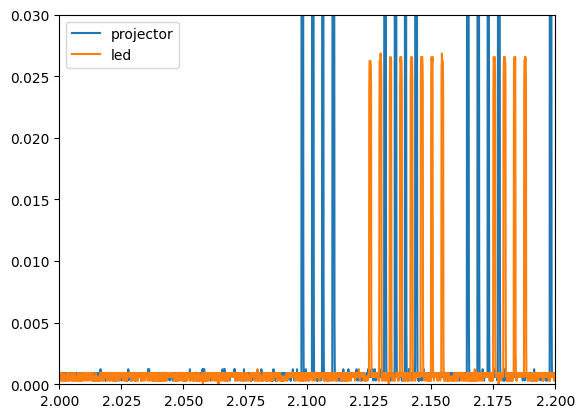

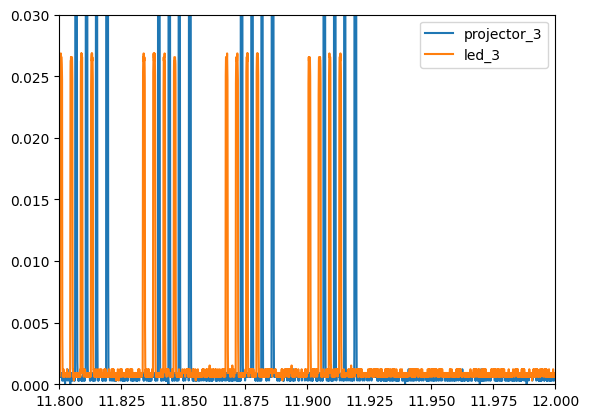

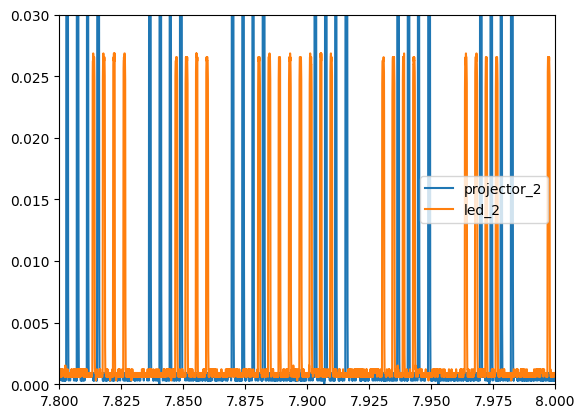

In [26]:
from Neitz import Neitz
from pathlib import Path
import matplotlib.pyplot as plt

projector = Neitz(filepath=Path.cwd())
projector.abfread("2026_01_01_0005_p.abf")
projector.stim_ch = (projector.stim_ch)*-1
projector.stim_ch = projector.stim_ch - min(projector.stim_ch)

led = Neitz(filepath=Path.cwd())
led.abfread("2026_01_01_0008_l.abf")
led.stim_ch = (led.stim_ch)*-1
led.stim_ch = led.stim_ch - min(led.stim_ch)

plt.plot(projector.time_vec ,projector.stim_ch)
plt.plot(led.time_vec ,led.stim_ch)
plt.axis([2, 2.2, 0, 0.03])
plt.legend(["projector", "led"])


plt.figure()
plt.plot(projector.time_vec ,projector.stim_ch)
plt.plot(led.time_vec ,led.stim_ch)
plt.axis([11.8, 12, 0, 0.03])
plt.legend(["projector_3", "led_3"])

plt.figure()
plt.plot(projector.time_vec ,projector.stim_ch)
plt.plot(led.time_vec ,led.stim_ch)
plt.axis([7.8, 8, 0, 0.03])
plt.legend(["projector_2", "led_2"])

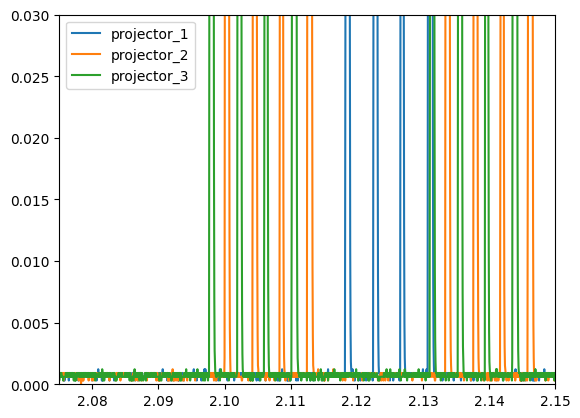

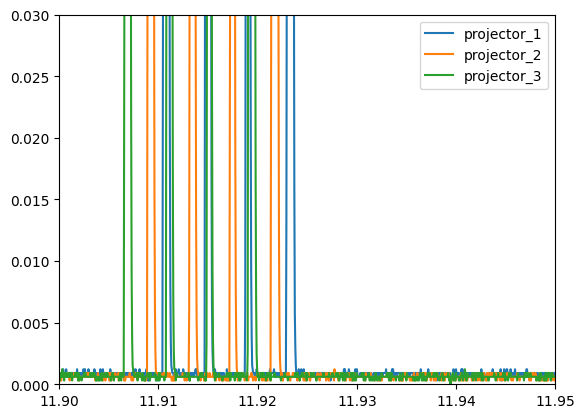

In [8]:
from Neitz import Neitz
from pathlib import Path
import matplotlib.pyplot as plt

projector = Neitz(filepath=Path.cwd())
projector.abfread("2026_01_01_0003_p.abf")
projector.stim_ch = (projector.stim_ch)*-1
projector.stim_ch = projector.stim_ch - min(projector.stim_ch)

projector1 = Neitz(filepath=Path.cwd())
projector1.abfread("2026_01_01_0004_p.abf")
projector1.stim_ch = (projector1.stim_ch)*-1
projector1.stim_ch = projector1.stim_ch - min(projector1.stim_ch)

projector2 = Neitz(filepath=Path.cwd())
projector2.abfread("2026_01_01_0005_p.abf")
projector2.stim_ch = (projector2.stim_ch)*-1
projector2.stim_ch = projector2.stim_ch - min(projector2.stim_ch)

plt.plot(projector.time_vec ,projector.stim_ch)
plt.plot(projector1.time_vec ,projector1.stim_ch)
plt.plot(projector2.time_vec ,projector2.stim_ch)
plt.axis([2.075, 2.15, 0, 0.03])
plt.legend(["projector_1", "projector_2", "projector_3"])


plt.figure()
plt.plot(projector.time_vec ,projector.stim_ch)
plt.plot(projector1.time_vec ,projector1.stim_ch)
plt.plot(projector2.time_vec ,projector2.stim_ch)
plt.axis([11.9, 11.95, 0, 0.03])
plt.legend(["projector_1", "projector_2", "projector_3"])

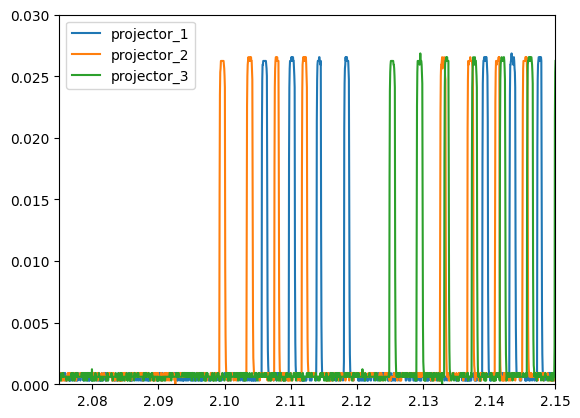

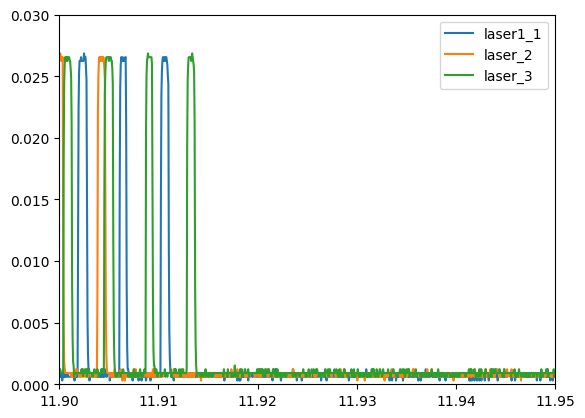

In [10]:
from Neitz import Neitz
from pathlib import Path
import matplotlib.pyplot as plt

projector = Neitz(filepath=Path.cwd())
projector.abfread("2026_01_01_0006_l.abf")
projector.stim_ch = (projector.stim_ch)*-1
projector.stim_ch = projector.stim_ch - min(projector.stim_ch)

projector1 = Neitz(filepath=Path.cwd())
projector1.abfread("2026_01_01_0007_l.abf")
projector1.stim_ch = (projector1.stim_ch)*-1
projector1.stim_ch = projector1.stim_ch - min(projector1.stim_ch)

projector2 = Neitz(filepath=Path.cwd())
projector2.abfread("2026_01_01_0008_l.abf")
projector2.stim_ch = (projector2.stim_ch)*-1
projector2.stim_ch = projector2.stim_ch - min(projector2.stim_ch)

plt.plot(projector.time_vec ,projector.stim_ch)
plt.plot(projector1.time_vec ,projector1.stim_ch)
plt.plot(projector2.time_vec ,projector2.stim_ch)
plt.axis([2.075, 2.15, 0, 0.03])
plt.legend(["projector_1", "projector_2", "projector_3"])


plt.figure()
plt.plot(projector.time_vec ,projector.stim_ch)
plt.plot(projector1.time_vec ,projector1.stim_ch)
plt.plot(projector2.time_vec ,projector2.stim_ch)
plt.axis([11.9, 11.95, 0, 0.03])
plt.legend(["laser1_1", "laser_2", "laser_3"])